# 0. Abstract and Outline

The purpose of this document is to extend the idea of basic CARTs. We incorporate the idea of ensemble learning (bagging and boosting in particular) and decision trees. We first introduce random forest (RF), which is an ensemble learning (specifically, bootstrap aggregation) approach that substantially reduces model variance. Random forest also has the advantage of high generalizability and is, therefore, a good benchmark model to start with. The second notable extension of CARTs is (extreme) gradient boosting trees (XGBT), which is also an ensemble learning (i.e., boosting) approach that significantly reduces model biases. Extreme gradient boosting trees have a great many of hyper-parameters, which have enabled this model to produce very competitive prediction performance with careful parameter fine-tuning. The modeling details, the case study, and the Python code are included in this document. 

Below is the outline of this document:

- In [Section 1](#section_6), we introduce ensemble learning and random forest, and revisit the Kwai retention prediction with the random forest model.

- In [Section 2](#section_7), we introduce gradient boosting tree, and apply this scalable model to Boston housing price prediction (regression) and the Kwai user retention prediction (classification).

- In [Section 3](#section_8), we give some thoughts on the value of RF and XGBT models in predictive modeling.

<a id='section_6'></a>
# 1. Ensemble Learning with Trees: Random Forest

In machine learning, it is a common practice to use multiple algorithms/models to build a stronger model and improve the prediction performance. Such a methodology is referred to as ensemble learning ([Wiki Page](https://en.wikipedia.org/wiki/Ensemble_learning)). One of the simplest ensemble learning approaches is to build different models and average the results. Such an intuitive approach works pretty well if the number of models increases as long as the models are not correlated. 

Among others, random forest is probably the most famous ensemble learning model. Random forest is built on the idea of bagging (Bootstrap AGGregating, where bootstrap means random sample with replacement [Wiki Page](https://en.wikipedia.org/wiki/Bootstrap_aggregating)), which is a systematic way of building "slightly different" models from the same training set. More specifically, we apply the following procedure to construct a random forest model:

----------

<font color="red">

- **Step 1. Bootstrapping:** Selecting $m$ random samples $n$ data points from the training set $\mathcal D$ **with replacement**. The random samples are denoted as $\{\mathcal D_1,\mathcal D_2,...,\mathcal D_m\}$.

- **Step 2. Constructing a random forest:** On each bootstrapped random sample $\mathcal D_k$ ($k=1,2,...,m$), train a decision tree $\hat T_k$ using recursive partitioning, in which each split is only on a random subset of the features $\{1,2,...,p\}$. The collection of fitted decision trees $\hat{RF}=\{\hat T_1,\hat T_2,...,\hat T_m\}$ forms a random forest.

</font>    
    
-----------


We remark that a random forest is constructed by randomization in two ways. First, for each tree, we select a bootstrapped random sample of the training data $\mathcal D$. Second, for each recursive split, we select a random subset of features. Both randomization helps reduce the correlation between different trees in $\hat{RF}$, thus yielding a strong performance in generalization. In particular, a random forest with more trees (a larger $m$) is always better. The two-way randomization of constructing a random forest can be illustrated in the figure where each row represents a data point and each column represent a feature, and the row with the same color represents the same data point in $\mathcal D$.

<img src="two-randomization.png" width=600>



As discussed above, predicting with the fitted random forest $\hat{RF}$ is to average the prediction result of all trees therein. Given a feature $X$, the random forest makes predictions as follows:

- **Classification Random Forest:** For each tree $\hat T_k\in\hat{RF}$, it predicts the probability of a positive outcome $\hat g_k(X)=\hat{\mathbb P}_k[Y=1|X]$. The entire forest will predict 

<font color="red">
$$\hat g(X)=\hat{\mathbb P}[Y=1|X]=\frac{1}{m}\sum_{k=1}^m\hat g_k(X) \in [0,1]$$
</font>
and the outcome variable
<font color="red">
$$\hat Y = \hat f(X) = 
\begin{cases}
1,\mbox{ if }\frac{1}{m}\sum_{k=1}^m\hat g_k(X)\ge t;\\
0,\mbox{ otherwise}
\end{cases}
$$
</font>    
for some classification threshold $t\in[0,1]$.

- **Regression Random Forest:** For each tree $\hat T_k\in\hat{RF}$, it directly predicts the outcome $\hat Y=\hat f_k(X)$. The entire forest will predict 
<font color="red">
$$\hat f(X)=\frac{1}{m}\sum_{k=1}^m\hat f_k(X)$$
</font>
The two-way randomization and the averaging helps produce a more stable and generalizable classifier/regresser, which is the main edge of random forest over decision tree. Random forest also reduces variance, and avoids overfitting. On the flip side of the coin, random forest is not as interpretable as decision tree. A pictorial illustration of a classification random forest model with 5 trees is given as follows, where regions with different colors present feature values that are predictive of different outcomes. It is clear from the figure that the random forest is much more stable (i.e., with smoother decision boundaries) than the classification trees therein.

<img src="RF-pic.png" width=1000>


To make sense of why random forest would give rise to more stable predictions, we note that the $m$ predictions of the individual trees with given feature $X$, $\hat Z_1,\hat Z_2,...,\hat Z_m$ are "almost" uncorrelated with the same distribution if $m$ is large ($\hat Z_i=\hat f_i(X)$ for regression and $\hat Z_i=\hat g_i(X)$ for classification, $i=1,2,...,m$). Hence, the variance of the aggregated estimator $\hat Z=\frac{1}{m}\sum_{i=1}^m\hat Z_i$ is
$$\mbox{Var}(\hat{Z})=\mbox{Var}\left(\frac{1}{m}\sum_{i=1}^m\hat Z_i\right)=\frac{1}{m^2}\mbox{Var}\left(\sum_{i=1}^m\hat Z_i\right)=\frac{1}{m^2}\sum_{i=1}^m\mbox{Var}(\hat Z_i)=\frac{1}{m}\mbox{Var}(\hat Z_1),$$
where the second equality follows from the quadratic scaling property of the variance operator, the third from that $Z_i$ and $Z_j$ are uncorrelated if $i \ne j$, and the last from that $Z_i$'s follow the same distribution. From the identity above, we can also conclude that the variance will decrease to 0 as the number of trees $m$ grows, which implies that more trees are better. This could also be viewed from the perspective of the Law of Large Numbers ([Wiki Page](https://en.wikipedia.org/wiki/Law_of_large_numbers)), which states the sample average of a large number of independent trials ($Z_i$'s in our setting) will be very close to the expected value and will tend to become closer to the expected value as more trials (the number of individual trees $m$ in our setting) are performed.

<a id='section_6.1'></a>
## 6.1. Case Study: Random Forest and Kwai Retention Prediction

Next, we use the random forest model to study the retention prediction problem of Kwai. You may check [this link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for more details about the ``RandomForestClassifier`` model in the ``sklearn`` package. As you can see, there are a lot of hyper-parameters you can fine-tune, which you will try in the next homework.

In [1]:
import sys 
import numpy as np
import pandas as pd
import statsmodels as sm
import sklearn
import scipy as sp
%matplotlib inline 
import matplotlib.pyplot as plt
import random

# Set the random seed such that the results are replicable.

random.seed(666)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split as tr_te_split

Load the Kwai retention data, which you should be very familiar with.

In [3]:
kwai_retention = pd.read_csv("Kwai_Retention.csv")
kwai_retention.head()

,user_id,retention,h_video,f_video,f_live,n_video,n_live,comment_duration,comment_num
0,1,1,14.333127,82.440787,50.715540,25.448967,31.928108,24.547305,2
1,2,0,0.000000,0.000000,169.315973,0.000000,100.053897,0.873836,0
2,3,1,24.886263,0.000000,8.932622,55.413817,136.752137,9.372263,1
3,4,0,180.547294,67.597604,0.000000,9.487704,13.855340,23.045255,2
4,5,1,124.664241,81.037966,156.721750,37.109027,0.000000,26.401544,3


Next, we randomly split the data into training (70%) and testing (30%) sets.

In [4]:
X = kwai_retention.drop(columns=['retention','user_id'])
y = kwai_retention['retention'].ravel()
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.3,random_state=666)

For model implementation convenience, we convert the outcome variable into factor and train a random forest.

In [5]:
kwaiForest = RandomForestClassifier(n_estimators=100)
# n_estimators is the number of trees in the random forest

In [6]:
# Train the model
kwaiForest.fit(X_train, y_train)

RandomForestClassifier()

In [7]:
# The importance of each feature.

df_kwai_feature_importance = pd.DataFrame({
    'Feature': kwai_retention.drop(columns=['retention','user_id']).columns,
    'Importance': kwaiForest.feature_importances_
})

df_kwai_feature_importance.style.hide_index()

Feature,Importance
h_video,0.173939
f_video,0.154019
f_live,0.163760
n_video,0.167540
n_live,0.144112
comment_duration,0.152856
comment_num,0.043774


The ``feature_importances_`` report the average amount of decrease in Gini Index associated with the splits on different features used to train the random forest. The larger the decrease, the more important the feature. See this [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_) for more details about this function. As we can see from the results, for the random forest model, the feature **h_video** makes the most important contribution to predicting the long-term retention.

Then, we predict, for the validation set, the positive probability probabilities, draw the ROC curve and compute the out-of-sample AUC.

The out-of-sample AUC for the random forest is 0.7073.


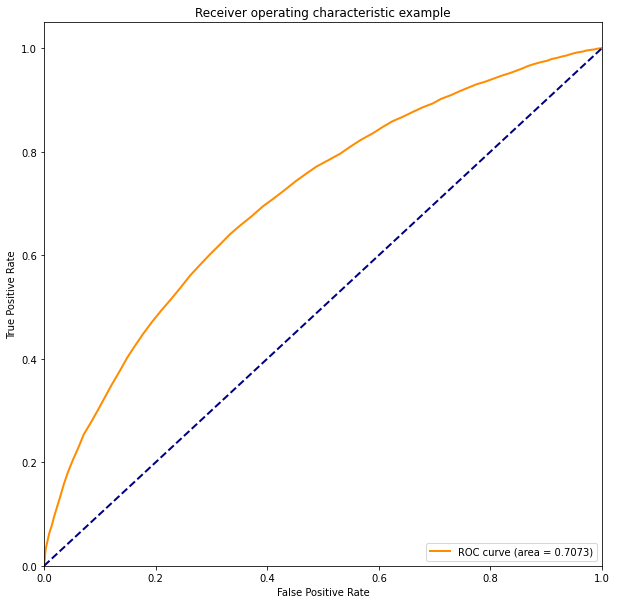

In [8]:
import matplotlib.pyplot  as plt
from sklearn.metrics import  roc_curve, auc
y_score=kwaiForest.predict_proba(X_test)
fpr,tpr,threshold = roc_curve(y_test, y_score[:,1])
roc_auc =auc(fpr,tpr)

print("The out-of-sample AUC for the random forest is %0.4f." % roc_auc)


plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

<a id='section_7'></a>
# 7. Ensemble Learning with Trees: (Extreme) Gradient Boosting Tree

Another important tree ensemble method is (gradient) boosting ([Wiki Page](https://en.wikipedia.org/wiki/Gradient_boosting#Gradient_tree_boosting), [Paper](https://arxiv.org/pdf/1603.02754.pdf)). The core idea of gradient boosting tree is

----------

<font color="red">
    
**To adaptively train a series of (simple) decision trees and add their prediction results together to form a new (stronger) tree with the objective to minimize the sum of the total training loss and the total regularization penalty.**     

</font>

------------

Before introducing the modeling framework and training paradigm of gradient boosting tree, we present a toy example that illustrates its idea. We want to predict the score that measures how much a user will like a computer game. The first tree is splitted on whether the age is below 20, the second tree is splitted on whether the user uses computer daily. The number below each leaf represents the score the tree predicts for a user therein.

<img src="Boosting-Tree.png" width=1000>

As shown in the above figure, the prediction of the boosting tree for each user's score is given by the sum of scores predicted by each individual tree. For a regression problem, the score is, naturally, the predicted outcome $\hat Y$; for a classification problem, the score is usually set as the predicted probability of positive outcome: $\hat{\mathbb P}[Y=1|X]$.

### Gradient Boosting Regressior Tree

We now introduce gradient boosting tree from a regression perspective. That from a classification perspective will be briefly discussed at the end. We consider adaptively fitting $k$ regression trees $\{\hat f_1(\cdot),\hat f_2(\cdot),...,\hat f_K(\cdot)\}$ on the training data $\mathcal D=\{Y_i,X_{ij}:1\le i\le n,1\le j\le p\}$, where $f_k(\cdot)\in\mathcal F$ for all $k$. Here, $\mathcal F$ the set of all regression trees. The integrated model $\hat f(\cdot)$ is the sum of all individual regression trees: 

<font color="red">
$$\hat Y = \hat f(X)=\sum_{k=1}^K \hat f_k(X)$$
</font>
    
The objective is to minimmize the regularized loss:

<font color="red">
$$\{\hat f_1(\cdot),\hat f_2(\cdot),...,\hat f_K(\cdot)\}=\mbox{argmin}_{f_k(\cdot)\in\mathcal F}\sum_{i=1}^n\mathcal L(Y_i,\hat f(X_i))+\sum_{k=1}^K R(f_k),$$
</font>

where we assume in this document training loss is the squared loss 

<font color="red">
$$\mathcal L(Y,\hat Y)=(Y-\hat Y)^2$$ 
</font>

and the complexity is defined as 

<font color="red">
$$R(f_k)=\gamma T+\frac{\lambda}{2}\sum_{\tau=1}^T w_{\tau}^2$$
</font>
    
    
with $T$ as the number of leaves for tree $f_k(\cdot)$ and $w_{\tau}$ as the predicted outcome value for each leaf $\tau$. Actually, $\gamma$ is the complexity parameter discussed above. The hyper-parameters $\gamma$ and $\lambda$ are to be fine tuned by cross-validation. For example, for the tree below with 3 leaves

<img src="Tree-Regularization.png" width=600>

The complexity is 

$$3\gamma+\frac{\lambda}{2}(2^2+0.1^2+1^2)=3\gamma+\frac{\lambda}{2}(4+0.01+1).$$ 


There are essentially 3 questions we need to address for constructing a gradient boosting tree.

--------

<font color="red">
    
- **Data:** For each individual tree, what data do we use to construct it?
- **Leaf outcome given tree structure:** Given the individual tree structure, how do we determine the value of each leaf?
- **Tree structure:** How do we determine the optimal structure of each individual tree?

</font>

--------

In the following, we address these 3 questions one by one.

### Data to Fit Each Individual Tree

Boosting refers to the adaptive training process that starts from a constant predictor $\hat Y\equiv 0$ and adds a new tree predictor each time. In each round $t$, the tree is trained on the residual of all models trained so far. Specifically,

------------------

<font color="red">

- **Round 1:** Train $\hat f_1(\cdot)$ on $\mathcal D_1=\{Y^{(1)}_i,X_{ij},1\le i\le n,1\le j\le p\}$, where $Y^{(1)}_i=Y_i$ for i=1,2,...,n.
- **Round 2:** Train $\hat f_2(\cdot)$ on $\mathcal D_2=\{Y^{(2)}_i,X_{ij},1\le i\le n,1\le j\le p\}$, where $Y^{(2)}_i=Y_i-\hat f_1(X_i)$ for i=1,2,...,n.
- ......
- **Round $t$:** Train $\hat f_t(\cdot)$ on $\mathcal D_t=\{Y^{(t)}_i,X_{ij},1\le i\le n,1\le j\le p\}$, where $Y^{(t)}_i=Y_i-\sum_{k=1}^{t-1}\hat f_k(X_i)$ for i=1,2,...,n.
- ......
- **Round $K$:** Train $\hat f_K(\cdot)$ on $\mathcal D_K=\{Y^{(K)}_i,X_{ij},1\le i\le n,1\le j\le p\}$, where $Y^{(K)}_i=Y_i-\sum_{k=1}^{K-1}\hat f_k(X_i)$ for i=1,2,...,n.

</font>
    
--------------------

The entire gradient boosting tree model is given by $\hat f(X)=\sum_{k=1}^K \hat f_k(X)$. 

### Determine the Leaf Outcome $\hat w_{\tau}$ Given the Individual Tree Structure

In particular, in each round $t$ of the adaptive training procedure above, the objective is to minimize the current regularized loss:


<font color="red">

$$\hat f_t(\cdot)=\mbox{argmin}_{f(\cdot)\in\mathcal F}\left\{\sum_{i=1}^n\mathcal L\left(Y_i,\sum_{s=1}^{t-1}\hat f_s(X_i)+f(X_i)\right)+R(f)\right\}=\mbox{argmin}_{f(\cdot)\in\mathcal F}\left\{\sum_{i=1}^n(Y_i^{(t)}-f(X_i))^2+\gamma T + \frac{\lambda}{2}\left(w_{\tau}(t)\right)^2\right\}$$

</font>
    
If the tree structure of tree for $\hat f_t(\cdot)$ is given, we define 

<font color="red">
    
$$G_{\tau}=2\left(\sum_{i\in \tau}Y^{(t)}_i\right),\mbox{ and }H_{\tau}=2|\tau|.$$ 

</font>    
Here, for node $\tau$, $G_{\tau}$ is the gradient of the loss function and $H_{\tau}$ is the Hessian of the loss function. The optimal predicted outcome for each leaf $\tau$, $\hat w_{\tau}(t)$, is given by

<font color="red">

$$\hat w_{\tau}(t)=\frac{G_{\tau}}{H_{\tau}+\lambda} $$

</font>    
    
Note that if $\lambda=0$, $\hat w_{\tau}(t)=\frac{G_{\tau}}{H_{\tau}}=\frac{1}{|\tau|}\sum_{i\in\tau} Y^{(t)}_{i}$, so this is reduced to the usual regression tree where the tree predicts the sample average of the leaf. Plugging the value of $\hat w_{\tau}(t)$ into the regularized loss/impurity, we have the optimal regularized loss/impurity is given by (with some constant terms ignored):

<font color="red">

$$-\frac{1}{2}\sum_{\tau=1}^T\frac{G_{\tau}^2}{H_{\tau}+\lambda}+\gamma T.$$
    
</font>

### Recursive Splitting Heuristic to Construct Each Individual Tree

Very similar to the usual way of recursively splitting the feature space to construct a single regression tree in a greedy fashion, in each round of individual decision tree training, we need to enumerate all the leave nodes and all the features to find the best split that gives rise to the largest decrease in total impurity/loss, $-\frac{1}{2}\sum_{\tau=1}^T\frac{G_{\tau}^2}{H_{\tau}+\lambda}$. The recursive splitting procedure to construct an individual tree will be stopped once the largest decrease of this impurity function does not exceed the complexity parameter $\gamma$. In fact, the decrease of the total regularized loss/impurity, which we call the gain, for a new split is:

<font color="red">
    
$$\mbox{Gain}=\frac{1}{2}\left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right]-\gamma,$$

</font>
where $G_{L}=2\left(\sum_{i\in \tau_L}Y^{(t)}_i\right)$, $H_{L}=2|\tau_L|$, $G_{R}=2\left(\sum_{i\in \tau_R}Y^{(t)}_i\right)$, and $H_{R}=2|\tau_R|$. The objective is to find a new split based on the current tree structure so that the Gain is maximized at each step of recursive partitioning to construct each tree.

To further prevent overfitting, we apply the shrinkage technique by scaling down the newly added individual tree by $\eta$ (called step-size or shrinkage, usually set around 0.1). This technique reduces the influence of each individual tree and leaves space for future trees to improve the model. We now recap the entire procedure to constructed a boosted tree:

----------

<font color="red">

- **Initialization and input:** Data $\mathcal D$ are put in the root node. Input the parameters $K$, $\lambda$, $\gamma$ and $\eta$.
- **Step 1:** Add a new tree in each iteration. For iteration $t$, $\mathcal D_t=\{Y^{(t)}_i,X_{ij},1\le i\le n,1\le j\le p\}$, where $Y^{(t)}_i=Y_i-\sum_{k=1}^{t-1}\eta \hat f_k(X_i)$ for i=1,2,...,n. Put all data points of $\mathcal D_t $ in the root node. 
- **Step 2:** For each leaf node $\tau$, split this node into two children nodes according to cutoffs in each feature $X_j$ and compute the optimal predicted outcome $\hat w_{\tau}(t)=\frac{G_{\tau}}{H_{\tau}+\lambda} $ and the optimal regularized loss/impurity $-\frac{1}{2}\sum_{\tau=1}^T\frac{G_{\tau}^2}{H_{\tau}+\lambda}+\gamma T$ of each resulting tree.
- **Step 3:** Select the constructed tree in **Step 2** with the largest Gain in the regularized loss. If the Gain is greater than 0, repeat **Step 2** to split another leaf; otherwise, add the final tree $\hat f_t(\cdot)$ to the model, and repeat **Step 1**.

</font> 

------------
    
We also remark that the idea of randomly sample a subset of features for each split (also called column subsampling) can also be applied to the gradient boosting tree. This technique could also further reduce overfitting in applications.  

The above boosting procedure can be well generalized to as a general **differentiable loss function** $\mathcal L(\cdot,\cdot)$. For example, in LogitBoost tree, 

$$\mathcal L (Y,\hat Y)=-Y\hat Y+\log(1+\exp(\hat Y)),$$

where $\hat Y$ is the predicted log-of-odds for the positive outcome.

Specifically, the predicted outcome value for leaf node $\tau$ to construct $\hat f_t(\cdot)$ is also given by 
$$\hat w_{\tau}=\frac{G_{\tau}}{H_{\tau}+\lambda},$$
where, for leaf $\tau$, $G_{\tau}=\sum_{i\in\tau}g_i$ with $g_i$ defined as the **gradient** (this is where the name **Gradient Boosting Tree** comes from) of the loss function $\mathcal L(Y_i,\cdot)$ with respect to $\hat Y_{i}$ evaluated at $\hat Y_i = \sum_{s=1}^{t-1}\hat f_{s}(X_i)$ for each $i\in \tau$, and $H_{\tau}=\sum_{i\in\tau}h_i$ with $h_i$ defined as the **Hessian** of the loss function  $\mathcal L(Y_i,\cdot)$ with respect to $\hat Y_{i}$ evaluated at $\hat Y_i = \sum_{s=1}^{t-1}\hat f_{s}(X_i)$ for each $i$. Similarly, the optimal regularized loss/impurity is given by:

$$-\frac{1}{2}\sum_{\tau=1}^T\frac{G_{\tau}^2}{H_{\tau}+\lambda}+\gamma T,$$

and the gain from each recursive split is given by:

$$\mbox{Gain}=\frac{1}{2}\left[\frac{G_L^2}{H_L+\lambda}+\frac{G_R^2}{H_R+\lambda}-\frac{(G_L+G_R)^2}{H_L+H_R+\lambda}\right]-\gamma.$$

Then, the gradient boosting tree algorithm can be implemented exactly in the same way as described above. We also emphasize that the gradient $G_{\tau}$ and Hessian $H_{\tau}$ can be computed well in advance before each split, making the procedure to grow a gradient boosting tree computationally convenient and scalable.  

Gradient boosting trees can also be applied to classification directly by viewing the outcome variable $Y\in\{0,1\}$ as a numeric variable. Then, the subsequent residuals after each round of tree-fitting $Y^{(t)}_i$ ($t=1,2,...,K$, $i=1,2,...,n$) will be a numeric value between 0 and 1. The final gradient boosting tree model $\hat f(X)=\sum_{t=1}^K \hat f_t(X)$ can be interpreted as the conditional positive probability given feature $X$, $\hat f(X)=\hat{\mathbb P}[Y=1|X]$.

Below, we give some illustrations on how the gradient boosting trees would be influenced by the number of individual models. 

**For gradient boosting regression trees:**

<img src="GBRT.png" width=600>

**For gradient boosting classification trees:**
<img src="GBCT.png" width=1000>

The extreme gradient boosting tree (XGBT) is a scalable end-to-end tree boosting system that leverages quite a few engineering novelties such as sparsity algorithms, parallel computing, and cache aware accesses. These system design innovations have substantially increases the speed and scalability of the system (see this [paper](https://arxiv.org/pdf/1603.02754.pdf) for more details). In general, gradient boosting trees are more accurate than random forest. In the next subsections, we demonstrate how to apply gradient boosting tree  to the hotel price prediction problem (regression) and the Kwai user retention prediction problem (classification).

The XGBT model has numerous hyper-parameters, such as:
- The random number of features for splitting each node;
- The maximum depth of the tree;
- The maximum number of leaf nodes of the tree;
- Regularization on each leaf node 
- Complexity parameter 
- The learning rate ;
- etc.

These hyper-parameters equip us with tremendous flexibilities to fine tune the XGBT model and make it stronger. You will be asked to use cross-validation to fine-tune these parameters to make a more predictive gradient boosting tree.

## 2.1. Demo of XGBT: Boston Housing Price Prediction

We now use the XGBT model to predict Boston housing price. We first load the ``xgboost`` package (you need to install it onto your computer first: ``pip install xgboost``; if this does not work, install it with ``conda install py-xgboost`` in the terminal).

If you are unable to install for some reason, you can try the ``sklearn.ensemble.GradientBoostingRegressor()`` (see [this link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)) and ``sklearn.ensemble.GradientBoostingClassifier()`` (see [this link](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)) in the ``sklearn`` package as an alternative.

In [9]:
import xgboost as xgb

Next, we load the data

In [10]:
df_BH = pd.read_csv("BostonHousing.csv")
df_BH.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


Split the data randomly into training (70%) and validation (30%) sets.

In [11]:
X = df_BH.drop(columns=['medv'])
y = df_BH['medv'].ravel()
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.3)

We are now ready to train a XGBT model for regression.

In [12]:
# Format the data correctly

data_train = xgb.DMatrix(data=X_train,label= y_train)
data_test = xgb.DMatrix(data=X_test,label= y_test)

In [13]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bynode=0.8,\
                          learning_rate = 0.1, gamma = 0.001,max_depth = 5,  n_estimators = 50)

We next compute the rooted mean squared error (RMSE).

In [14]:
from sklearn.metrics import mean_squared_error as mse

xgb_reg.fit(X_train,y_train)

preds = xgb_reg.predict(X_test)

rmse = np.sqrt(mse(y_test, preds))

print("The RMSE is %0.4f." % (rmse))

The RMSE is 2.6864.


 Below, we introduce the parameters we used:


- **n_estimators = 50**: The number of individual trees.
- **max_depth = 5**: The maximum depth of each individual tree.
- **learning_rate = 0.1**: The shrinkage parameter.
- **gamma=0.001**: The complexity parameter.
- **lambda = 1**: $L^2$-regularizer's coefficient.
- **colsample_bynode=0.8**: For each split at a node, the proportion of variables to use.
- **objective = "reg:squarederror"**: The training loss function. Here we specify as squared error.

The reported result, **rmse** means the rooted mean squared error:

$$\mbox{RMSE}=\sqrt{\frac{1}{n}\sum_{i=1}^n(Y_i-\hat f(X_i))^2}$$

Next, we report the feature importance of the fitted XBGT model to predict the Boston Housing prices, which is defined in a similar fashion as the importance metric for the RF model.

In [15]:
xgb_reg.get_booster().get_score(importance_type='gain')

{'crim': 35.2101936340332,
 'zn': 2.9859116077423096,
 'indus': 75.63155364990234,
 'chas': 8.466615676879883,
 'nox': 142.27041625976562,
 'rm': 348.3531494140625,
 'age': 13.182106018066406,
 'dis': 57.521976470947266,
 'rad': 19.956947326660156,
 'tax': 19.482227325439453,
 'ptratio': 21.977628707885742,
 'b': 14.902859687805176,
 'lstat': 584.3749389648438}

From the results we know that the variables **lstat** (neighborhood) and **rm** (number of rooms) are most important.

In [16]:
from sklearn.metrics import r2_score

print("The out-of-sample R-squared of the XGB regression tree is %0.4f." % r2_score(y_test, xgb_reg.predict(X_test)))

The out-of-sample R-squared of the XGB regression tree is 0.9033.


As we can see, the XGBT model is very accurate in this case (with out-of-sample $R^2$ as high as 0.89).

## 7.2. Demo of XGBT: Kwai User Retention Prediction

We apply the gradient boosting tree model to the Kwai user retention problem, which is a classification in nature. First, we load the data. 

In [17]:
kwai_retention = pd.read_csv("Kwai_Retention.csv")
kwai_retention.head()

,user_id,retention,h_video,f_video,f_live,n_video,n_live,comment_duration,comment_num
0,1,1,14.333127,82.440787,50.715540,25.448967,31.928108,24.547305,2
1,2,0,0.000000,0.000000,169.315973,0.000000,100.053897,0.873836,0
2,3,1,24.886263,0.000000,8.932622,55.413817,136.752137,9.372263,1
3,4,0,180.547294,67.597604,0.000000,9.487704,13.855340,23.045255,2
4,5,1,124.664241,81.037966,156.721750,37.109027,0.000000,26.401544,3


Randomly split the data into training and testing sets.

In [18]:
X = kwai_retention.drop(columns=['retention','user_id'])
y = kwai_retention['retention'].ravel()
X_train, X_test, y_train, y_test = tr_te_split(X, y, test_size=0.3, random_state=666)

In [19]:
data_train = xgb.DMatrix(data=X_train,label= y_train)
data_test = xgb.DMatrix(data=X_test,label= y_test)

Fit an XGBT model on the training data set.

In [20]:
kwai_xgbt = xgb.XGBClassifier(objective ='binary:logistic', eval_metric='logloss',colsample_bynode=0.8, learning_rate = 0.1,gamma = 0.001,
                max_depth = 10, n_estimators = 50,use_label_encoder=False)


In [21]:
def printCM(tn, fp, fn, tp):
    print('{: <9} {: <9} {: <9}'.format(' ',' ','predicted'))
    print('         --------------------')
    print('{: <9}|{: <9d}|{: <9d}'.format('Actual',0,1))
    print('-----------------------------')
    print('{: <9d}|tn={: <6d}|fp={: <9d}'.format(0,tn,fp))
    print('-----------------------------')
    print('{: <9d}|fn={: <6d}|tp={: <9d}'.format(1,fn,tp))

In [22]:
from sklearn.metrics import confusion_matrix

kwai_xgbt.fit(X_train,y_train)

y_pred = kwai_xgbt.predict(X_test)

# Draw the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

printCM(tn, fp, fn, tp)

                    predicted
         --------------------
Actual   |0        |1        
-----------------------------
0        |tn=2861  |fp=6239     
-----------------------------
1        |fn=2080  |tp=18820    


For this classification problem, we change the objective argument using ``objective = 'binary:logistic'``, which specifies that we use the logistic loss function (also called the cross entropy) $\mathcal L (Y,\hat Y)=-Y\hat Y+\log(1+\exp(\hat Y))$ when training the XGBT model, where $\hat Y$ is the predicted log-of-odds. 

We also calculate the feature importance based on the fitted XBGT model.

In [23]:
kwai_xgbt.get_booster().get_score(importance_type='gain')

{'h_video': 4.504045486450195,
 'f_video': 5.790534496307373,
 'f_live': 5.068438529968262,
 'n_video': 9.861715316772461,
 'n_live': 5.810097694396973,
 'comment_duration': 3.3778395652770996,
 'comment_num': 2.789293050765991}

From the XGBT results we observe that, **n_video** makes the most important contribution to predicting user long-term retention, which is slightly different from the random forest model. Finally, we draw the ROC curve and compute the AUC.

The out-of-sample AUC for the XBGT is 0.7229


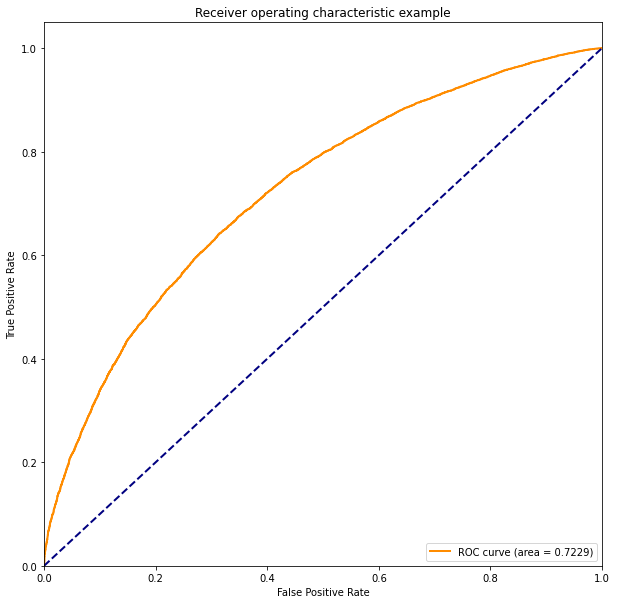

In [24]:
from sklearn.metrics import  roc_curve, auc
y_score=kwai_xgbt.predict_proba(X_test)
fpr,tpr,threshold = roc_curve(y_test, y_score[:,1])
roc_auc =auc(fpr,tpr)

print("The out-of-sample AUC for the XBGT is %0.4f" % roc_auc)


plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

 As we can see, the XGBT model is much faster than random forest and would yield a (slightly) better prediction performance than the logistic regression model.

### Cross-Validation

For the examples above, we do not discuss how to use $k$-fold cross-validation to fine-tune the (very rich) hyper-parameters of random forests and gradient boosting trees. It is suggested that you use the ``GridSearchCV()`` function of ``sklearn`` to fine-tune your designated choices/grids of hyper-parameters. You will try the details of the next homework problem set. For a reference, please see [this link for the random forest model](https://www.kaggle.com/sociopath00/random-forest-using-gridsearchcv) and [this link for the XGBT model](https://www.kaggle.com/phunter/xgboost-with-gridsearchcv).   

<a id='section_8'></a>
# 3. Concluding Remarks

Finally, we conclude this document with some brief discussions on random forests and gradient boosting trees:

- **Random forests** are **stable**, **robust**, and **reducing over-fitting**. So they generally serve as **very good benchmarks** for further model building.

- With the engineering and system innovation in **(extreme) gradient boosting trees**, this model could produce very competitive prediction performance with careful fine-tuning of hyper-parameters. 